In [ ]:
from Classes.Analysis import Analysis
import numpy as np
from matplotlib import pyplot as plt
from Classes.Visualizer import Visualizer
from scipy.integrate import solve_ivp
from SALib.sample import sobol as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer
from SALib import ProblemSpec
import pandas as pd

class System(Analysis):
    def __init__(self, graph_location):
        super().__init__(graph_location)

    def odesystem(self, t, Y, *params):
        #TODO: look at biology side, try to replicate graphs
        #TODO: explore the model(s)
        # start simple, bacteria-resource, see how the bacteria and reosurces grow/shrink, bacteria should hit carrying capacity, nutrient should reach 0, not negative, etc
        graph_object, phage_nodes, bacteria_nodes, nutrient_nodes, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix = params
        graph = graph_object.graph
        def g(N, v, K):
            return (N * v) / (N + K)

        Y = self.check_cutoff(Y)
        
        N, U, I, P = self.unflatten_initial_matrix(Y, [len(nutrient_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)])
        new_N = np.zeros_like(N)
        new_U = np.zeros_like(U)
        new_I = np.zeros_like(I)
        new_P = np.zeros_like(P)
        #update N vector
        for nutrient in nutrient_nodes:
            n_index = nutrient_nodes.index(nutrient)
            e_value = e_vector[n_index] 
            sum_g = 0
            sum_u = 0
            sum_i = 0
            for bacteria in bacteria_nodes:
                b_index = bacteria_nodes.index(bacteria)
                if graph.has_edge(bacteria, nutrient):
                    v = v_matrix[b_index, n_index]
                    K = K_matrix[b_index, n_index]
                    sum_g += g(N[n_index], v, K)
                    sum_u += U[b_index]
                    sum_i += np.sum(I[b_index])
            new_N[n_index] = -(e_value * sum_g) * (sum_u + sum_i)
        
        # update U vector, i, and j are flipped relative to what is seen in update N vector for v, K, and r matrices because of how the row and columns are defined in the graph
        # dont sum U in left and right, because we are looking at an individual bacteria
        for uninfected in bacteria_nodes:
            u_index = bacteria_nodes.index(uninfected)
            g_sum = 0
            right = 0
            for nutrient in nutrient_nodes:
                n_index = nutrient_nodes.index(nutrient)
                if graph.has_edge(uninfected, nutrient):
                    g_sum += g(N[n_index], v_matrix[u_index, n_index], K_matrix[u_index, n_index])
            for phage in phage_nodes:
                p_index = phage_nodes.index(phage)
                if graph.has_edge(phage, uninfected):
                    right += r_matrix[p_index, u_index] * P[p_index]
            new_U[u_index] = g_sum * U[u_index] - right * U[u_index]

        for infected in bacteria_nodes:
            i_index = bacteria_nodes.index(infected)
            for infected_stage in range(0, M):
                if infected_stage == 0:
                    left_sum = 0
                    right_sum = 0
                    for phage in phage_nodes:
                        p_index = phage_nodes.index(phage)
                        if graph.has_edge(phage, infected):
                            left_sum += r_matrix[p_index, i_index] * P[p_index]
                            right_sum += M / tau_vector[i_index] * I[i_index, 0]
                    new_I[i_index, 0] = left_sum * U[i_index] - right_sum
                else:
                    m_tau = M / tau_vector[i_index]
                    right = I[i_index, infected_stage - 1] - I[i_index, infected_stage]
                    new_I[i_index, infected_stage] = m_tau * right
        
        for phage in phage_nodes:
            p_index = phage_nodes.index(phage)
            left_sum = 0
            right_sum = 0
            for infected in bacteria_nodes:
                i_index = bacteria_nodes.index(infected)
                if graph.has_edge(phage, infected):
                    left_sum += B_matrix[p_index, i_index] * M / tau_vector[i_index] * I[i_index, -1]
                    right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index])) * P[p_index]
            new_P[p_index] = left_sum - right_sum

        flattened_y1 = self.flatten_lists_and_matrices(new_N, new_U, new_I, new_P)
        return flattened_y1

graph = System('simple_test_2.gexf')
phage_nodes = graph.get_nodes_of_type('P')
bacteria_nodes = graph.get_nodes_of_type('B')
resource_nodes = graph.get_nodes_of_type('R')
environemnt_nodes = graph.get_nodes_of_type('E')

R0 = graph.initialize_new_parameter_from_node(resource_nodes, "Initial_Concentration")
U0 = graph.initialize_new_parameter_from_node(bacteria_nodes, "Initial_Population")
I0 = graph.initialize_new_matrix(len(U0), graph.M)
P0 = graph.initialize_new_parameter_from_node(phage_nodes, "Initial_Population")

e_vector = graph.initialize_new_parameter_from_node(resource_nodes, 'e')
tau_vector = graph.initialize_new_parameter_from_node(bacteria_nodes, 'tau')
v_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'v')
K_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'K')
r_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'r')
B_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'Burst_Size')
visualizer = Visualizer(graph)
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]

problem_spec = ProblemSpec({
    'num_vars': 9,
    'names': ["R", "U", "P", 'e', 'tau', 'v', 'K', 'r', 'B'],
    'bounds': [[1, 10000], [1, 10000], [1, 10000], [0.01, 2], [0.01, 2], [0.01, 2], [0.01, 20], [0.01, 2], [10, 200]]
})

In [2]:
param_values = sobol_sampler.sample(problem_spec, N=2**10, seed = 0, calc_second_order=False)

t_start = 0
t_end = 10
t_steps = 100
t_eval = np.linspace(t_start, t_end, t_steps)
def evaluate_model(params):
    flattened[0] = params[0]
    flattened[1] = params[1]
    flattened[6] = params[2]
    e_vector[0] = params[3]
    tau_vector[0] = params[4]
    v_matrix[0, 0] = params[5]
    K_matrix[0, 0] = params[6]
    r_matrix[0, 0] = params[7]
    B_matrix[0, 0] = params[8]
    list_to_pass = [graph, phage_nodes, bacteria_nodes, resource_nodes, int(graph.M), e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix]
    sol = solve_ivp(graph.odesystem, (t_start, t_end), flattened, args=tuple(list_to_pass), t_eval=t_eval)
    return sol

Z_final = np.zeros((len(param_values), 4))
Z_avg = np.zeros((len(param_values), 4))
Z_var = np.zeros((len(param_values), 4))
Z_average_rate_of_change = np.zeros((len(param_values), 4))
Z_variance_rate_of_change = np.zeros((len(param_values), 4))

for i, p in enumerate(param_values):
    solved_system = evaluate_model(p)
    overall_y = graph.unflatten_initial_matrix(solved_system.y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
    overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))
    overall_y = np.array(overall_y)
    Z_final[i, :] = overall_y[:, :, -1].reshape(4)
    Z_avg[i, :] = np.mean(overall_y[0], axis=1)
    Z_var[i, :] = np.var(overall_y[0], axis=1)
    Z_average_rate_of_change[i, :] = np.mean(np.diff(overall_y[0], axis=1), axis=1)
    Z_variance_rate_of_change[i, :] = np.var(np.diff(overall_y[0], axis=1), axis=1)

np.save('Z_final.npy', Z_final)
np.save('Z_avg.npy', Z_avg)
np.save('Z_var.npy', Z_var)
np.save('Z_average_rate_of_change.npy', Z_average_rate_of_change)
np.save('Z_variance_rate_of_change.npy', Z_variance_rate_of_change)

In [3]:
final_analyzed = []
avg_analyzed = []
var_analyzed = []
rate_avg_analyzed = []
rate_var_analyzed = []
for i in range(Z_final.shape[1]):
    final_analyzed.append(sobol_analyzer.analyze(problem_spec, Z_final[:, i], calc_second_order=False))
    avg_analyzed.append(sobol_analyzer.analyze(problem_spec, Z_avg[:, i], calc_second_order=False))
    var_analyzed.append(sobol_analyzer.analyze(problem_spec, Z_var[:, i], calc_second_order=False))
    rate_avg_analyzed.append(sobol_analyzer.analyze(problem_spec, Z_average_rate_of_change[:, i], calc_second_order=False))
    rate_var_analyzed.append(sobol_analyzer.analyze(problem_spec, Z_variance_rate_of_change[:, i], calc_second_order=False))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning:

invalid value encountered in divide



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



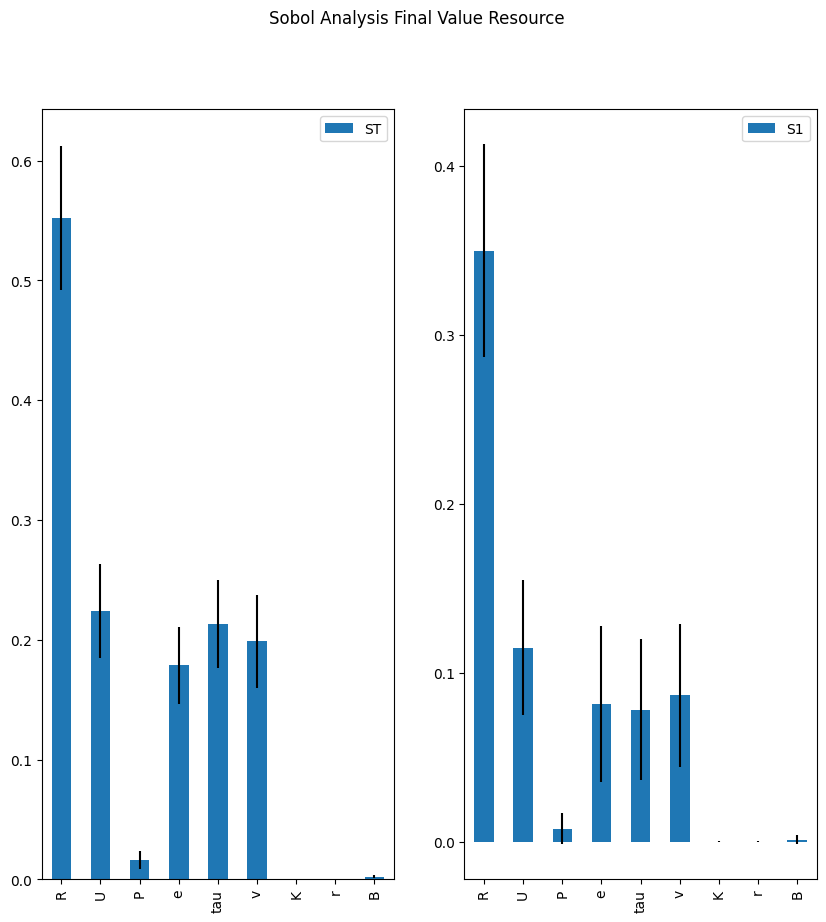

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



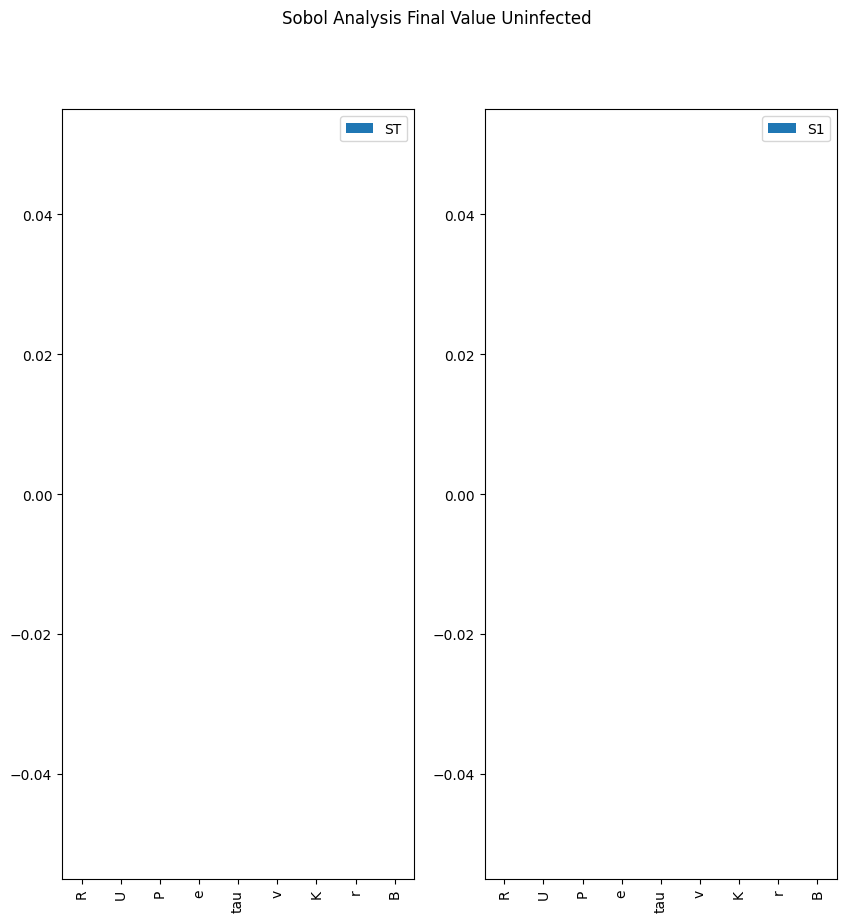

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



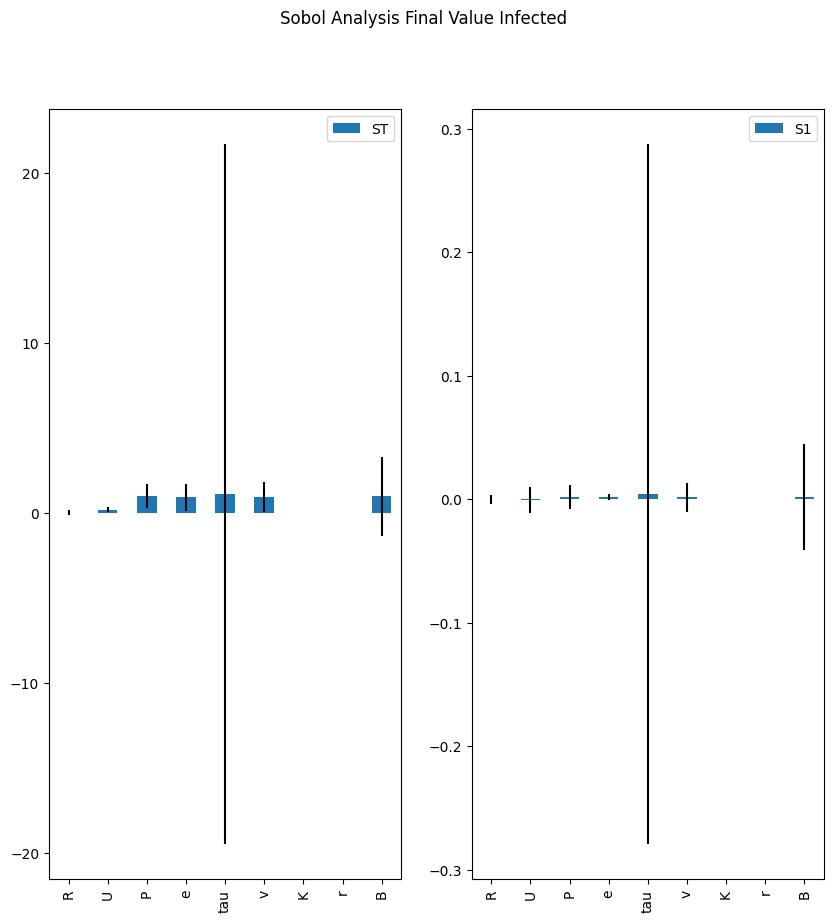

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



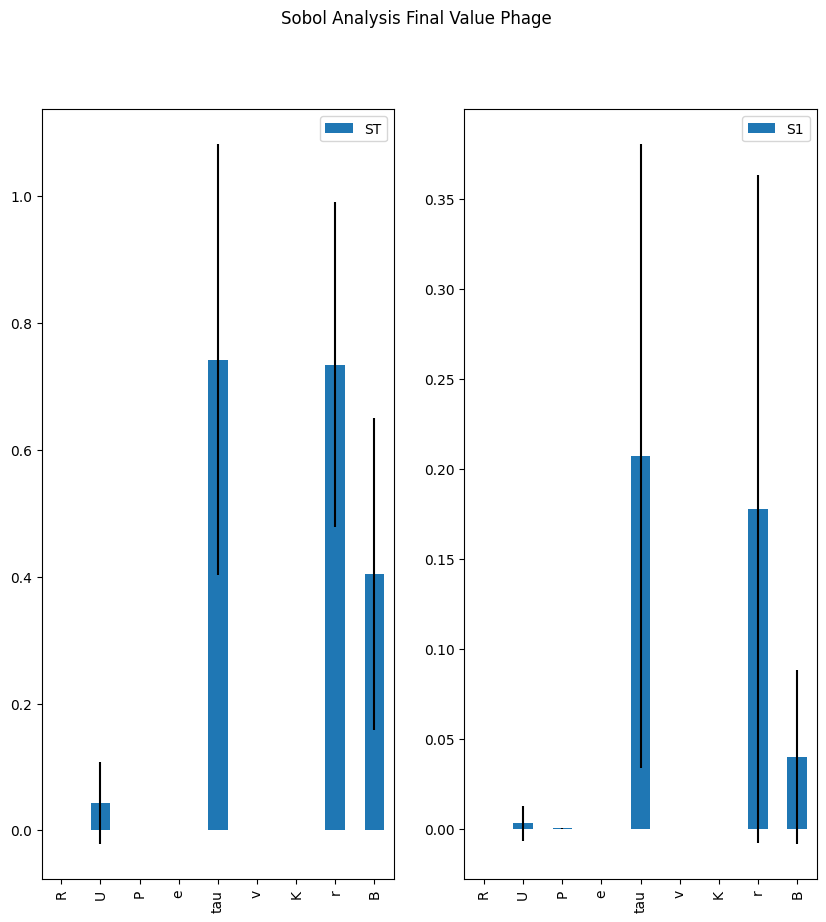

In [9]:
for analyzed, title in zip(final_analyzed, ['Resource', 'Uninfected', 'Infected', 'Phage']):
    axes = analyzed.plot()
    fig = axes[0].figure 
    fig.set_size_inches(10, 10) 
    fig.suptitle('Sobol Analysis Final Value {}'.format(title))
    plt.show()

# sesnitivity analysis from https://gsa-module.readthedocs.io/en/develop/implementation/gsa.html

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



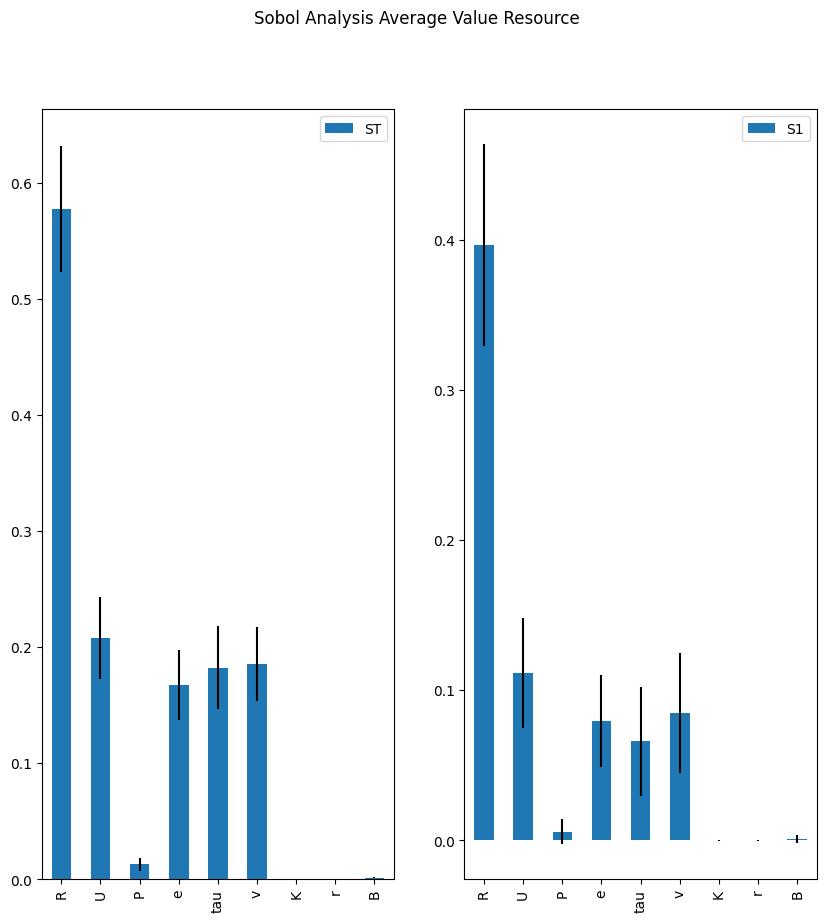

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



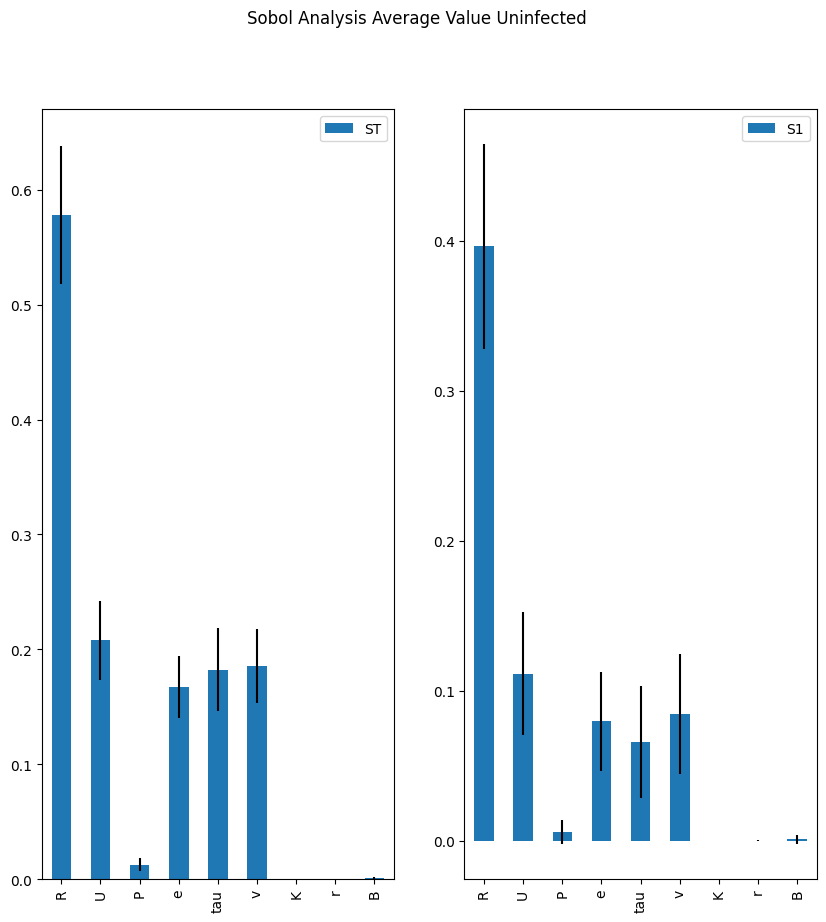

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



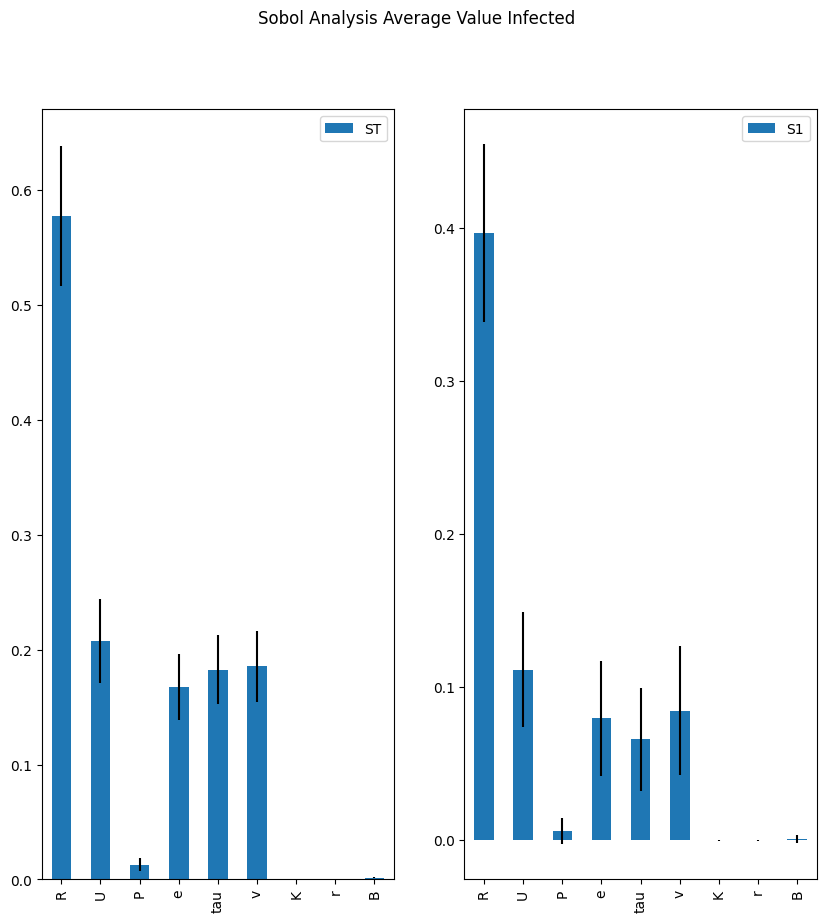

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



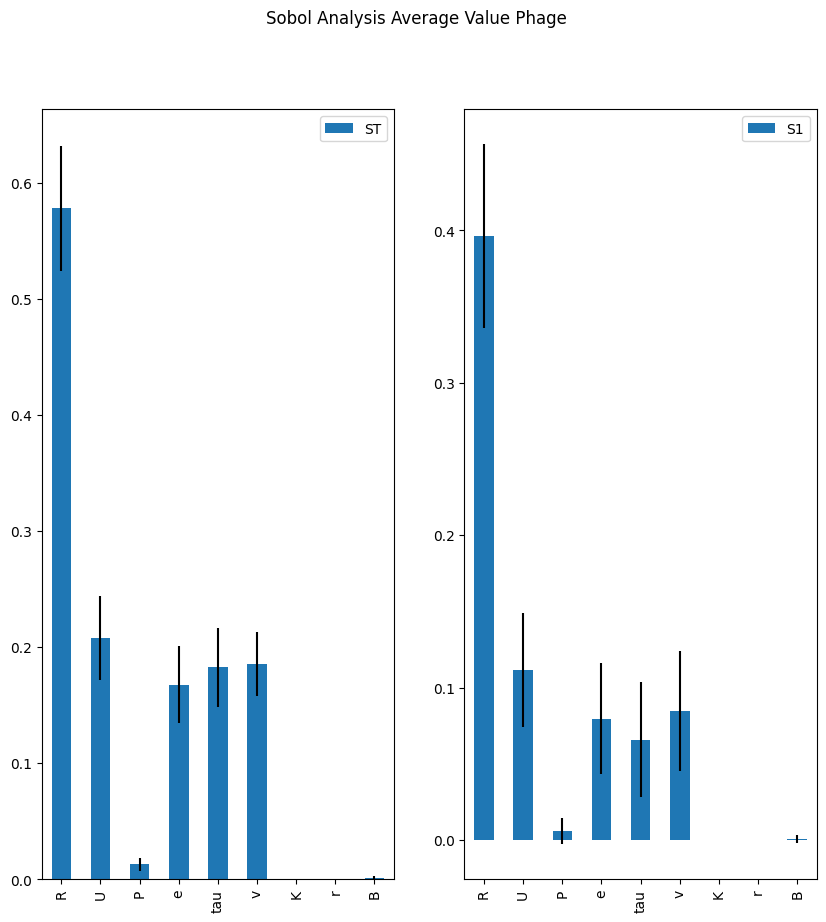

In [10]:
for analyzed, title in zip(avg_analyzed, ['Resource', 'Uninfected', 'Infected', 'Phage']):
    axes = analyzed.plot()
    fig = axes[0].figure 
    fig.set_size_inches(10, 10) 
    fig.suptitle('Sobol Analysis Average Value {}'.format(title))
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



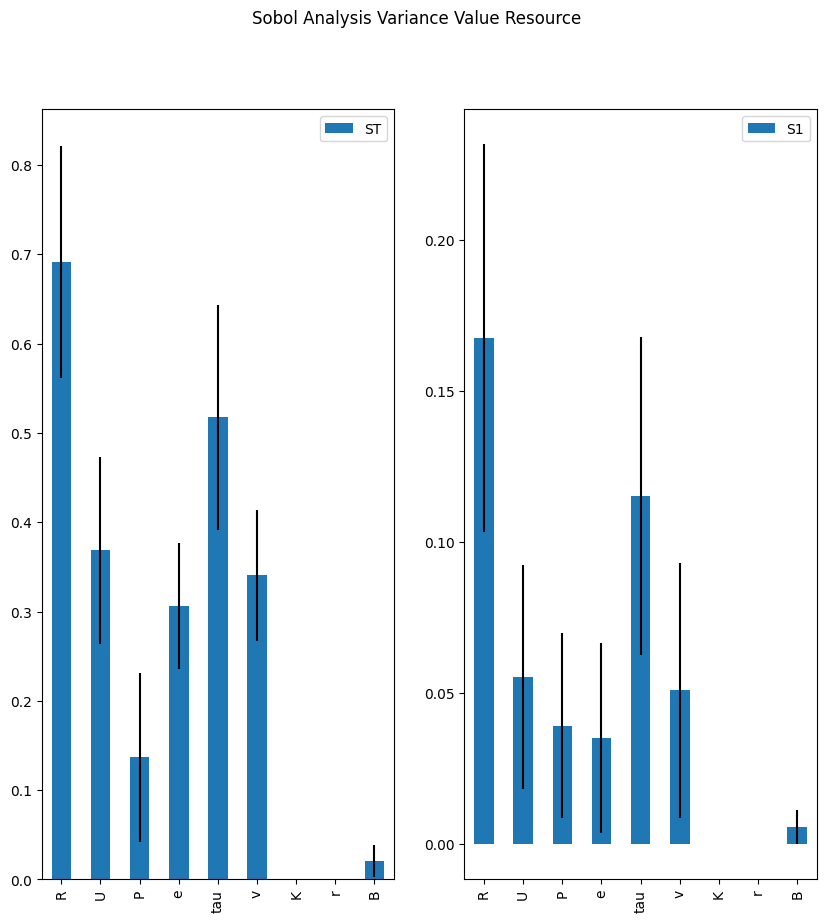

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



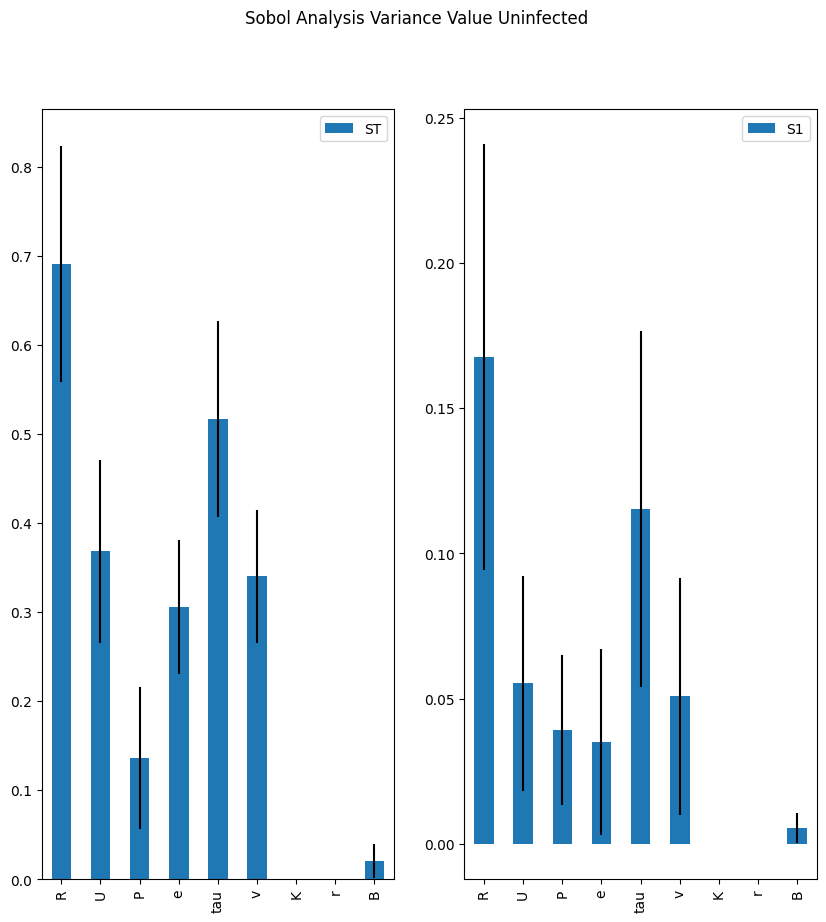

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



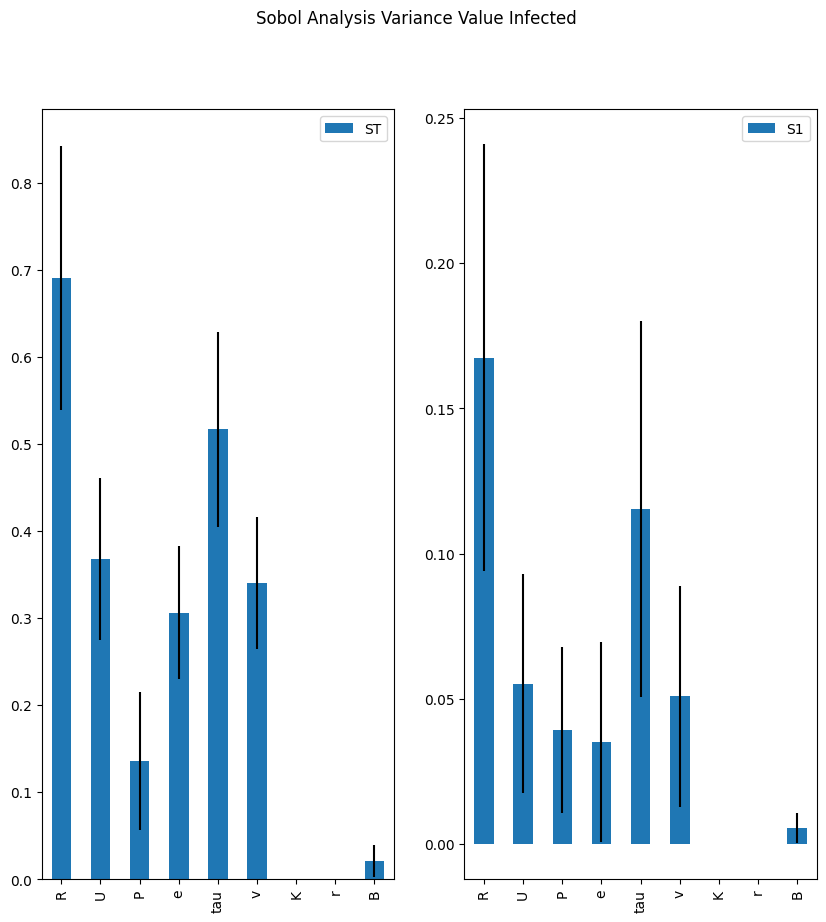

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



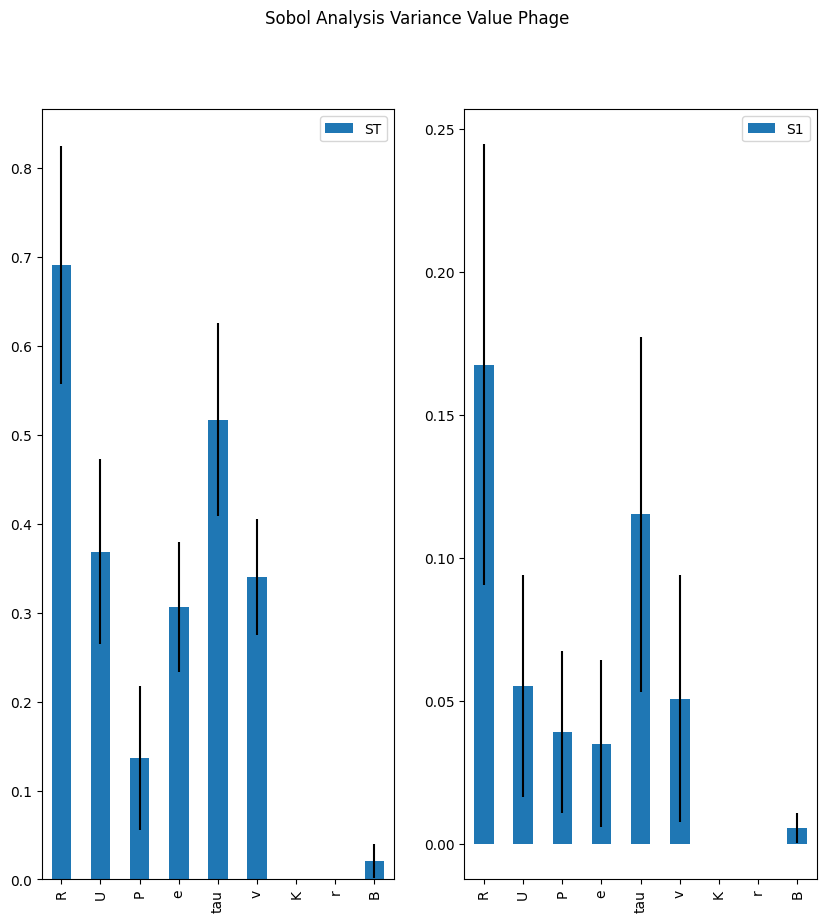

In [11]:
for analyzed, title in zip(var_analyzed, ['Resource', 'Uninfected', 'Infected', 'Phage']):
    axes = analyzed.plot()
    fig = axes[0].figure 
    fig.set_size_inches(10, 10) 
    fig.suptitle('Sobol Analysis Variance Value {}'.format(title))
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



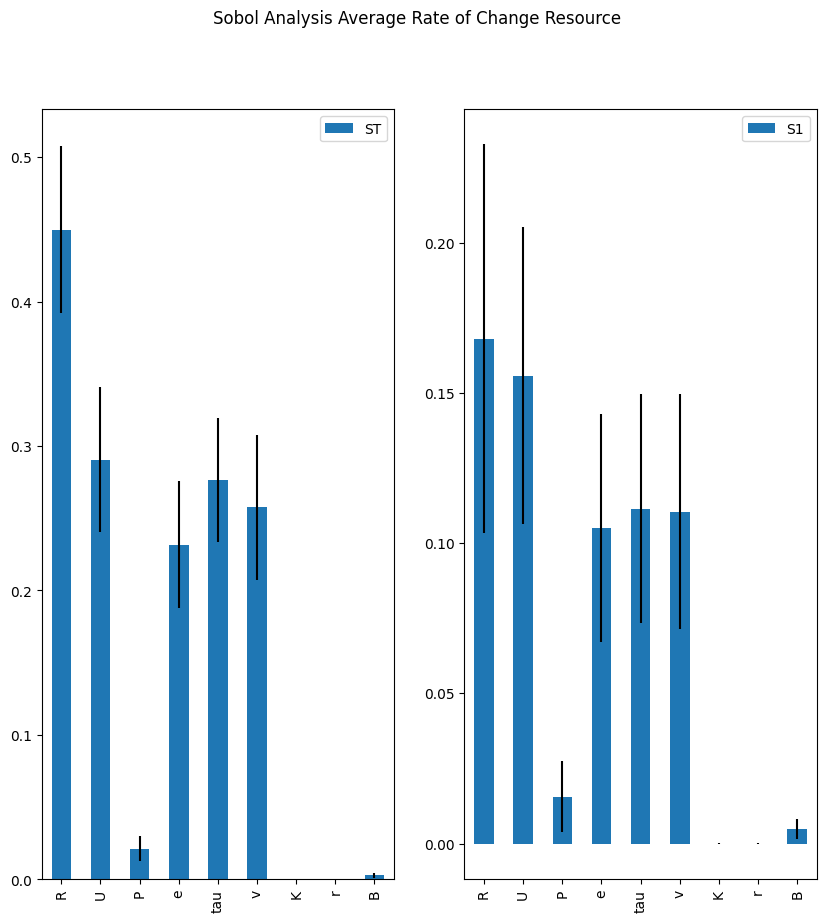

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



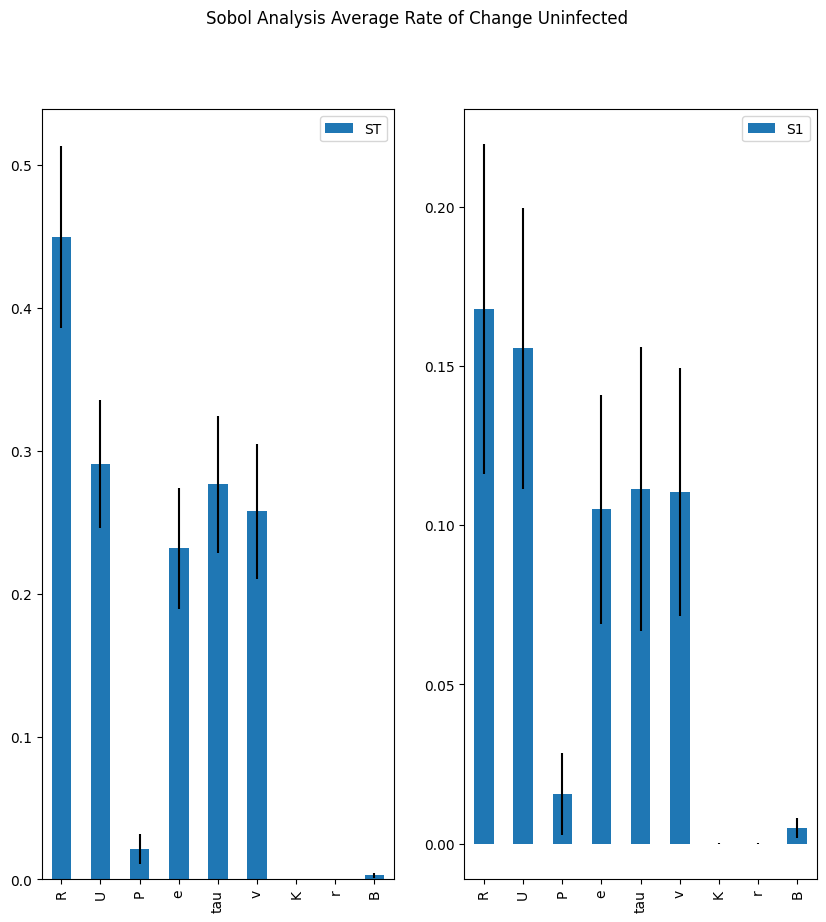

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



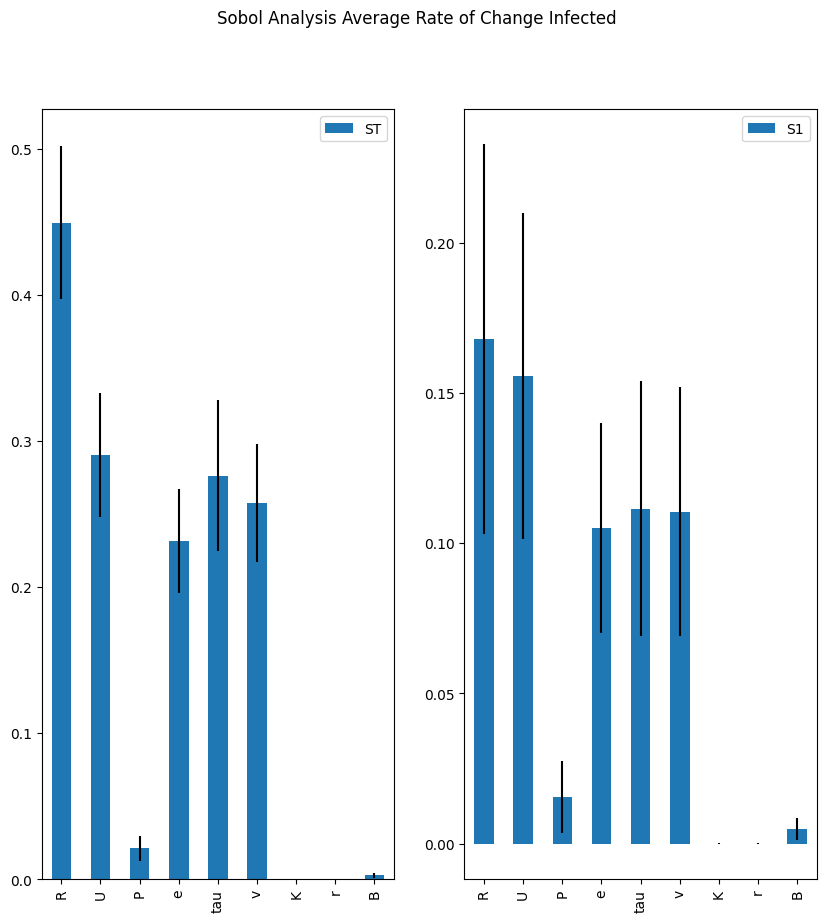

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



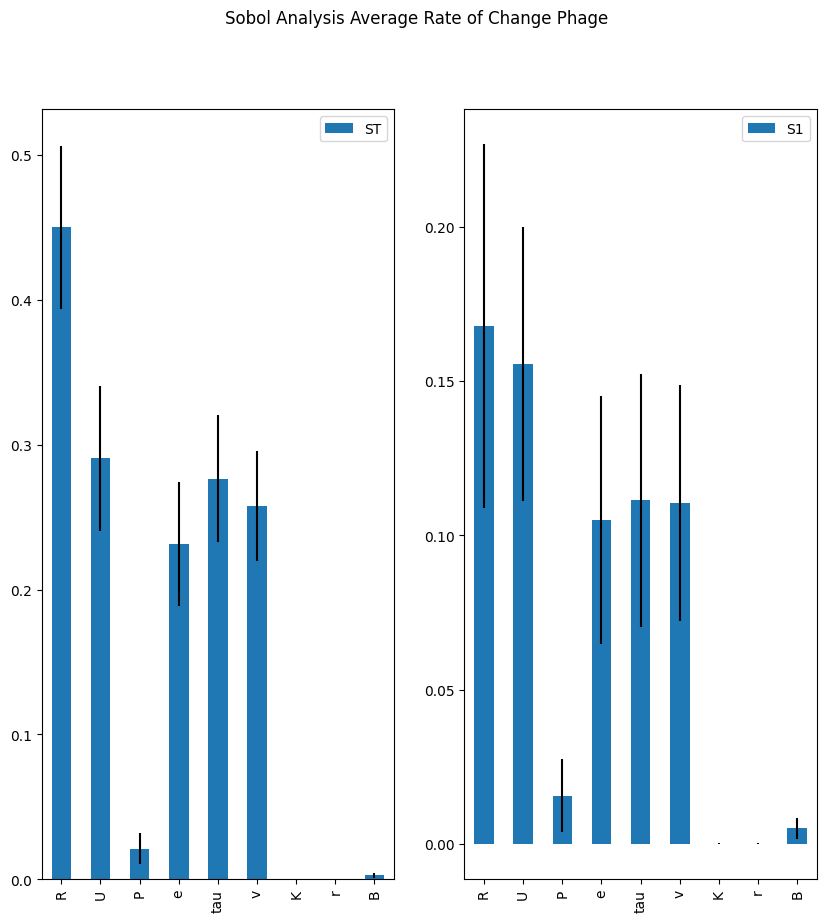

In [12]:
for analyzed, title in zip(rate_avg_analyzed, ['Resource', 'Uninfected', 'Infected', 'Phage']):
    axes = analyzed.plot()
    fig = axes[0].figure 
    fig.set_size_inches(10, 10) 
    fig.suptitle('Sobol Analysis Average Rate of Change {}'.format(title))
    plt.show()

In [13]:
for analyzed in zip(rate_var_analyzed, ['Resource', 'Uninfected', 'Infected', 'Phage']):
    axes = analyzed.plot()
    fig = axes[0].figure
    fig.set_size_inches(10, 10)
    fig.suptitle('Sobol Analysis Varaince Rate of Change {}'.format(title))
    plt.show()

AttributeError: 'tuple' object has no attribute 'plot'